# It's PCH time

In [ ]:
"""
Pseudo-code
- Do it inline for memory issues
- Compute the foreground
- Accumulate on the accumulation map
"""

In [1]:
# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import glob

from skimage.filters import scharr, threshold_otsu
from skimage.util.shape import view_as_blocks
from skimage import feature
import skimage.measure
from scipy import stats


TypeError: unhashable type: 'numpy.ndarray'

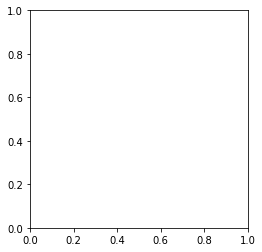

In [2]:
import re
def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    return sorted(l, key = alphanum_key)

plt.gray()
videos = glob.glob('/usagers2/jusimc/travail/Downloads/aic19-track3-train-data/*.mp4')
videos = natural_sort(videos)

cap = cv2.VideoCapture(videos[0])
n_frames = int(cap.get(7))
    
subtractor = cv2.createBackgroundSubtractorMOG2(history=20, varThreshold=25, detectShadows=True)

i = 0
while i < n_frames:
    _, frame = cap.read()

    mask = subtractor.apply(frame)

    plt.imshow(frame)
    plt.imshow(mask)
    
cap.release()

In [2]:
def comp_grads(video):
    cap = cv2.VideoCapture(video)
    i = 0
    n_frames = int(cap.get(7))
    max_frames = n_frames

    rows = int(cap.get(4)) 
    cols = int(cap.get(3))
    n_blocks_row = rows // ppc
    n_blocks_col = cols // ppc
    fps = int(cap.get(5))
    nb_frames = max_frames//sampling + 1
    fds = np.zeros((rows, cols, nb_frames))
    print(max_frames//sampling + 1, "frames")

    j=0
    while i < max_frames:
        ret, image = cap.read()
        if i%sampling == 0:
            img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            fd = scharr(img_gray)
            fds[:,:,j] = fd
            j+=1
        i+=1
        print('\r',  (i/max_frames)*100 , end='')

    cap.release()
    return fds

#grads = comp_grads(videos[4])
#print(grads.shape)

In [3]:
def to_cells(images):
    rows = images.shape[0] 
    cols = images.shape[1] 
    nb_frames = images.shape[2]
    offx = rows % ppc
    offy = cols % ppc
    return view_as_blocks(images[:rows-offx,:cols-offy, :], block_shape=(ppc, ppc, nb_frames)).squeeze()

#grads_grid = to_cells(grads)

In [4]:
# Let's try to display magnitudes
def comp_magnitudes(images):
    n_blocks_row = images.shape[0]
    n_blocks_col = images.shape[1]
    nb_frames = images.shape[-1]
    magnitudes = np.zeros((n_blocks_row, n_blocks_col, nb_frames))
    ims = []
    for t in range(nb_frames):
        for i in range(n_blocks_row):
            for j in range(n_blocks_col):
                magnitudes[i,j,t] = np.sum(images[i,j,:,:,t])
    return magnitudes

#magnitudes = comp_magnitudes(grads_grid)

In [5]:
#plt.matshow(magnitudes[:,:,13], cmap=plt.cm.viridis)
#plt.colorbar()

In [6]:
#plt.plot(range(nb_frames), magnitudes[2,0,:])
#plt.plot(range(nb_frames), magnitudes[29,1,:])

In [7]:
from scipy.signal import find_peaks

def gaussian_fct(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def get_peaks2(signal):
    peaks, props = find_peaks(signal, prominence = 1)
    w = gaussian_fct(len(peaks), mu=1, sig=5) * np.max(stats.zscore(signal))
    if len(peaks == 1):
        return (w, peaks[0])
    else:
        return(0, 0)
    
def get_peaks(signal):
    return np.max(stats.zscore(signal))
  
def get_maxconv(signal, filter, p = False):
    signal -= np.average(signal)
    signal_step = np.convolve(signal, filter, mode='valid')
    # get the peak of the convolution, its index
    step_indx = np.argmax(signal_step) 
    if p:
        plt.plot(signal)
        plt.plot(signal_step/10)
        plt.plot((step_indx, step_indx), (signal_step[step_indx]/10, 0), 'r')
    return (signal_step[step_indx], step_indx) 

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

def doorconv(signal):
    maxi = 0
    for width in [40, 60]:
        for pos in range(0, len(signal) - width, width):
            door = np.hstack((-1*np.ones(pos),
                            1*np.ones(width),
                             -1*np.ones(len(signal) - pos - width)))
            maxi = max(maxi, get_maxconv(signal, door)[0])
    return maxi

In [8]:
def compute_anomaly(signals, filter):
    n_blocks_row = signals.shape[0]
    n_blocks_col = signals.shape[1]
    res = np.zeros((n_blocks_row, n_blocks_col, 2))
    # Let's plot the magnitudes through time
    for i in range(n_blocks_row):
        for j in range(n_blocks_col):
            res[i,j,0] = get_maxconv(signals[i,j,:], filter)[0]
            res[i,j,1] = get_maxconv(signals[i,j,:], filter)[1]
            #stop_n_go[i,j,0] = get_peaks2(magnitudes[i,j,:])[0]
            #stop_n_go[i,j,1] = get_peaks2(magnitudes[i,j,:])[1]
    return res
# Filters
"""
step = np.hstack((np.ones(nb_frames), -1*np.ones(nb_frames)))
door = np.hstack((-1*np.ones(nb_frames//6), 1*np.ones(nb_frames//3), -1*np.ones(nb_frames)))
    
go_stop = compute_anomaly(magnitudes, step)
stop_go = compute_anomaly(magnitudes, -step)
"""
# stop_n_go = np.zeros((n_blocks_row, n_blocks_col, 2))

'\nstep = np.hstack((np.ones(nb_frames), -1*np.ones(nb_frames)))\ndoor = np.hstack((-1*np.ones(nb_frames//6), 1*np.ones(nb_frames//3), -1*np.ones(nb_frames)))\n    \ngo_stop = compute_anomaly(magnitudes, step)\nstop_go = compute_anomaly(magnitudes, -step)\n'

In [9]:
#get_maxconv(magnitudes[13,88,:], step, p = verb)

In [10]:
"""
x = magnitudes[36,0,:]
#x = magnitudes[29,1,:]
door = np.hstack((-1*np.ones(10),
                            1*np.ones(40),
                             -1*np.ones(len(x) - 10 - 40)))
#x =door
print(np.var(x))
peak, props = find_peaks(x, prominence = 1, plateau_size = 1)
plt.plot(x)
plt.plot(peak, x[peak], "x")
"""
#print(props)
#print(peak)
#signaltonoise(x)
#print(np.max(stats.zscore(x)))
#print(stats.variation(x))
#print(np.max(stats.zscore(y)))
#print(stats.variation(y))
#print(np.max(np.ediff1d(x)))
#print(np.percentile([stats.variation(x[i:i+2]) for i in range(len(x)-2)], 99))
#print(np.mean([stats.variation(x[i:i+5]) for i in range(len(x)-5)]))

'\nx = magnitudes[36,0,:]\n#x = magnitudes[29,1,:]\ndoor = np.hstack((-1*np.ones(10),\n                            1*np.ones(40),\n                             -1*np.ones(len(x) - 10 - 40)))\n#x =door\nprint(np.var(x))\npeak, props = find_peaks(x, prominence = 1, plateau_size = 1)\nplt.plot(x)\nplt.plot(peak, x[peak], "x")\n'

In [27]:
# Extract the starting and ending time of the anomalies
# For step signals : we use 1/SNR to determine if there is an 
# anomaly
from skimage.morphology import erosion
from skimage.morphology import square
from skimage.filters import median, gaussian
from skimage.morphology import disk
def locate_anomaly(image, seuil, p = False):
    n_blocks_row = image.shape[0]
    n_blocks_col = image.shape[1]
    #image[:,:,0] =  (image[:,:,0] - np.min(image[:,:,0])) / np.ptp(image[:,:,0])
    blobs_dog = feature.blob_log(image[:,:,0],
                                 min_sigma = 2, 
                                 num_sigma=1,
                                 max_sigma = 4,
                                 overlap=0,
                                 threshold = seuil)
                                 #threshold=np.percentile(image[:,:,0], 95))

    if p:
        fig=plt.figure(figsize = (15,15))
        ax=fig.add_subplot(1,1,1)
        for blob in blobs_dog:
            y, x, r = blob
            c = plt.Circle((x, y), r+1, color='red', linewidth=2, fill=False)
            ax.add_patch(c)
        plt.imshow((image[:,:,0]))
        plt.show()
  
    idx = []
    if p:
        print(str(len(blobs_dog)) + " anomalie.s")
    for a in blobs_dog:
        a = a.astype(int)
        idxs = []
        try:
            thresh = threshold_otsu(image[a[0]-1:a[0]+1,a[1]-1:a[1]+1,0])
        except ValueError:
            thresh = image[a[0], a[1], 0]
            
        for i in range(max(0, a[0]-1), min(a[0]+1+1, n_blocks_row)):
            for j in range(max(0, a[1]-1), min(a[1]+1+1, n_blocks_col)):
                if image[i,j,0] >= thresh:
                    idxs.append(image[i,j,1])
                 
        idx.append(np.bincount(idxs).argmax())
        print(a)
    return idx
"""
an_go_stop = locate_anomaly(go_stop[:,:], p = verb)
if an_go_stop:
    print(np.min(an_go_stop) * sampling / fps, max_frames // fps)
    
an_stop_go = locate_anomaly(stop_go[:,:], p = verb)
if an_stop_go:
    print(0, np.max(an_stop_go) * sampling / fps)
"""
"""
tmp = np.zeros((n_blocks_row, n_blocks_col, 2))
tmp[:,:,0] = cv2.resize(
            skimage.measure.block_reduce(stop_n_go[:,:,0],
                                         (2,2), np.min)
            , dsize=(n_blocks_col, n_blocks_row)
            , interpolation=cv2.INTER_AREA)
tmp[:,:,1] = stop_n_go[:,:,1]
"""
"""
an_stop_n_go = locate_anomaly(stop_n_go[:,:]*9, p = verb)
if an_stop_n_go:
    print(0, np.max(an_stop_n_go)/9 * sampling / fps)
"""

'\nan_stop_n_go = locate_anomaly(stop_n_go[:,:]*9, p = verb)\nif an_stop_n_go:\n    print(0, np.max(an_stop_n_go)/9 * sampling / fps)\n'

In [13]:

# Paramètres globaux
cap = cv2.VideoCapture(videos[0])
i = 0
ppc = 8
n_frames = int(cap.get(7))
max_frames = n_frames
verb = True
fps = int(cap.get(5))
sampling=30
cap.release()
start = time. time()
an_go_stop_vec = []
an_stop_go_vec = []
for video in videos:
    print(video)
    grads = comp_grads(video)
    grads_grid = to_cells(grads)
    magnitudes = comp_magnitudes(grads_grid)
    nb_frames = magnitudes.shape[2]
    step = np.hstack((np.ones(nb_frames), -1*np.ones(nb_frames)))
    
    go_stop = compute_anomaly(magnitudes, step)
    stop_go = compute_anomaly(magnitudes, -step)
    
    an_go_stop_vec.append(go_stop[:,:,0])
    an_stop_go_vec.append(stop_go[:,:,0])
    """
    an_go_stop = locate_anomaly(go_stop[:,:], p = verb)
    if an_go_stop:
        print(np.min(an_go_stop) * sampling / fps, max_frames // fps)

    an_stop_go = locate_anomaly(stop_go[:,:], p = verb)
    if an_stop_go:
        print(0, np.max(an_stop_go) * sampling / fps)
    """  
end = time. time()
print(end - start)

/usagers2/jusimc/travail/Downloads/aic19-track3-train-data/1.mp4
895 frames
 100.06271578240945443.568099623429402/usagers2/jusimc/travail/Downloads/aic19-track3-train-data/2.mp4
895 frames
 100.062714392244665641.338553318419092.7964205816554816.96868008948545910.56301267710663664.4481730052199991.28262490678598/usagers2/jusimc/travail/Downloads/aic19-track3-train-data/3.mp4
893 frames
 100.0626391690951466510.47224090263767660.3377419113801171.8187252484495282.53007546887842/usagers2/jusimc/travail/Downloads/aic19-track3-train-data/4.mp4
896 frames
 100.062776847198957531.928159315093988610.29220174948818212.51070165643030137.3385445747254839.9255536943979145.6616415410385352.7191513121161456.58663688814442663.8935417829890274.4798064396054484.667783361250799.67615857063093/usagers2/jusimc/travail/Downloads/aic19-track3-train-data/5.mp4
895 frames
 100.0627546649782436514.6672129315803231.08123207568251857.56266527617416558.929569071473875.5186412901784180.02532682781481/usagers2/jus

 100.062470914959265644.28206860316745418.56939127824063726.81453126172783654.54477219845380659.16835547549350659.6449748555130267.6912106882834271.9319972979058889.67199579674248/usagers2/jusimc/travail/Downloads/aic19-track3-train-data/45.mp4
890 frames
 100.062529976019143551.46133093525179858.22467026378896910.74265587529976/usagers2/jusimc/travail/Downloads/aic19-track3-train-data/46.mp4
896 frames
 100.0627657593923446429.36664556726365736.60498194139330558.2194586141415664.8992813791562681.28979409464944/usagers2/jusimc/travail/Downloads/aic19-track3-train-data/47.mp4
890 frames
 100.0625117150892635/usagers2/jusimc/travail/Downloads/aic19-track3-train-data/48.mp4
895 frames
 100.0627407876598634512.62342114087708151.89463094750177453.9774209173218159.2570513059353965.594843325012184.88766347479414/usagers2/jusimc/travail/Downloads/aic19-track3-train-data/49.mp4
895 frames
 100.0627143922446656417.09917971662938317.5130499627143927.9604772557792751.0738255033557160.8873974645786

 100.062541204674854573.08285885525921513.7998201977824471.42643092598142/usagers2/jusimc/travail/Downloads/aic19-track3-train-data/91.mp4
901 frames
 100.0629766753054666533.15438726397630464.3613476490188893.32469455757128/usagers2/jusimc/travail/Downloads/aic19-track3-train-data/92.mp4
889 frames
 100.062501874906264513.54807259637018118.26908654567271737.36313184340783563.03434828258587468.96655167241637/usagers2/jusimc/travail/Downloads/aic19-track3-train-data/93.mp4
893 frames
 100.062644751587544618.95031751961150628.95031751961150654.0679865521105754.4714232349645155.7078819574150258.98020171834142694.35188644004484/usagers2/jusimc/travail/Downloads/aic19-track3-train-data/94.mp4
895 frames
 100.0627185624279664677.09428475562018/usagers2/jusimc/travail/Downloads/aic19-track3-train-data/95.mp4
895 frames
 100.0627143922446656426.5249813571961251.4392244593586951.81580909768829574.0044742729306584.6644295302013597.8523489932886/usagers2/jusimc/travail/Downloads/aic19-track3-trai

<Figure size 432x288 with 0 Axes>

In [14]:
# Nouveau workflow pour les anomalies :
# 1. Récupérer toutes les réponses
# 2. Stats sur les réponses : valeurs maximales, histogrammes
# 3. Utiliser ces stats pour faire un seuil
# 4. Binairisation ? Non max suppression ? Juste blob avec nouveau seuil ?
# 5. Pour les blobs : convolutio ?
# 6. Extraction de stats rapides en préalable ?

7686.608249150217 0.0 [ 215.42099313  432.53528837 1179.05779692]


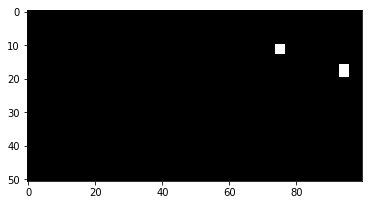

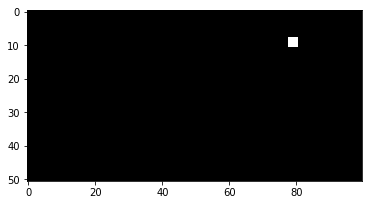

[12 74  2]
[10 80  2]
Video 2 go stop
0.0 894


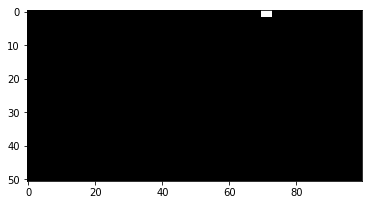

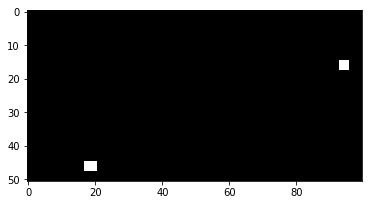

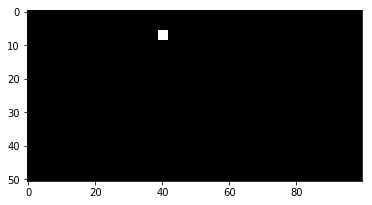

[16  0  2]
Video 5 go stop
0.0 894


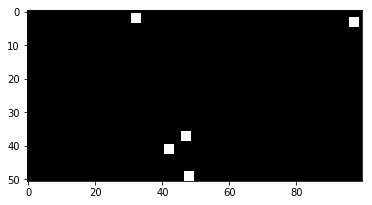

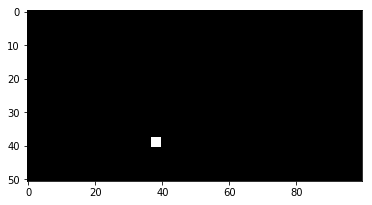

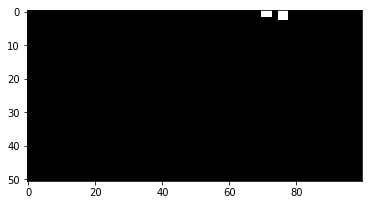

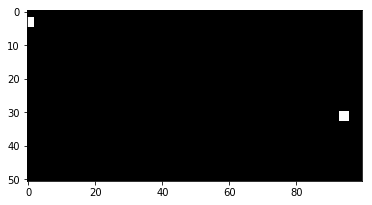

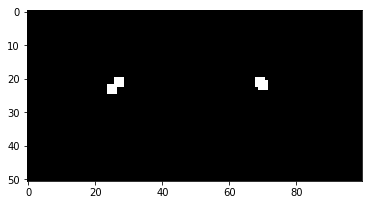

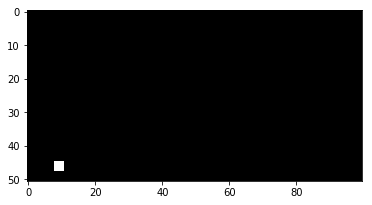

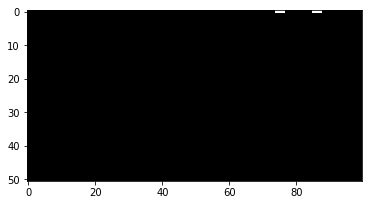

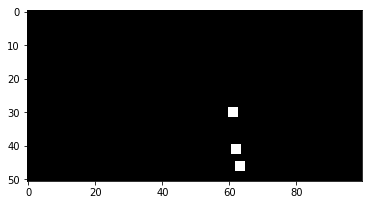

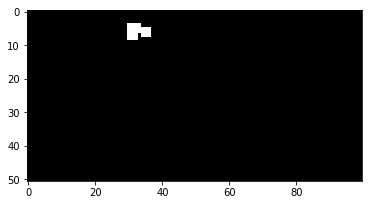

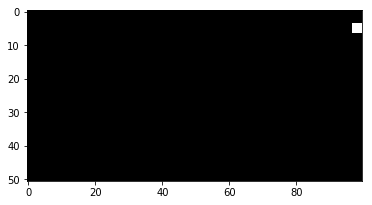

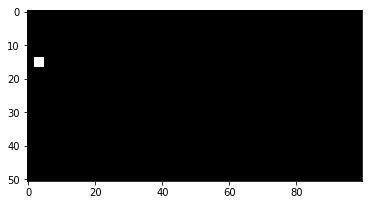

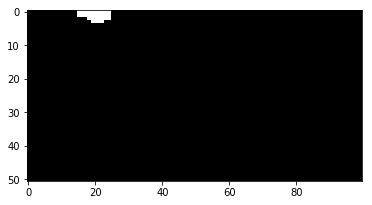

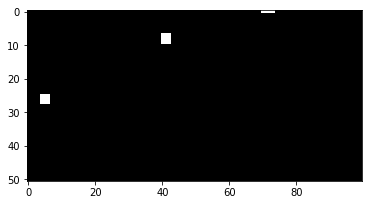

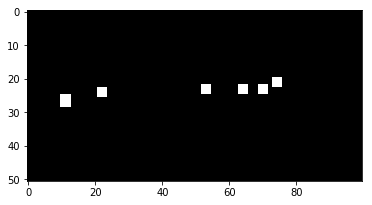

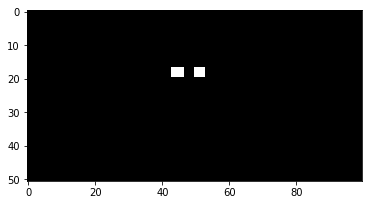

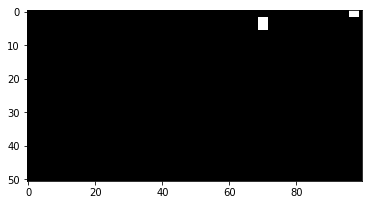

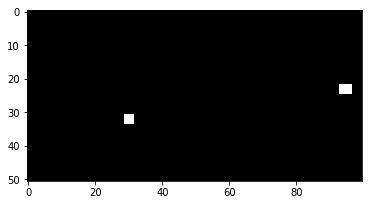

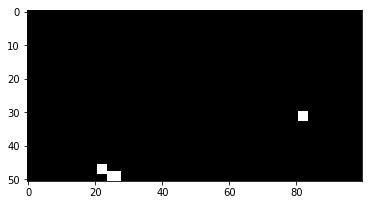

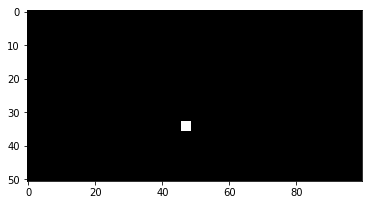

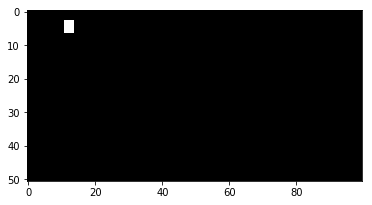

[ 6 13  2]
Video 25 go stop
0.0 894


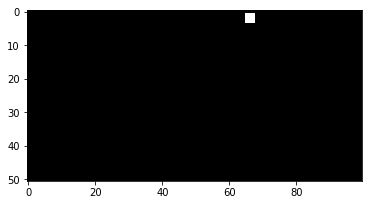

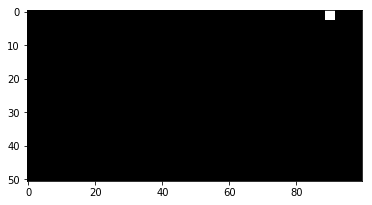

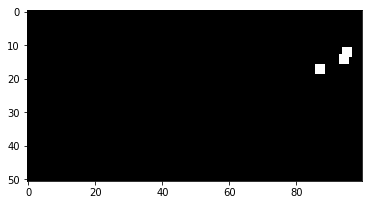

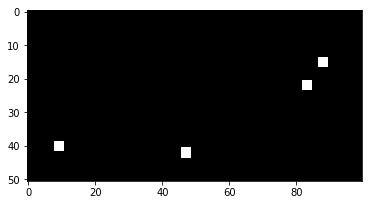

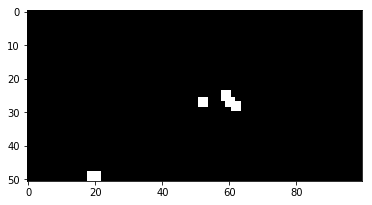

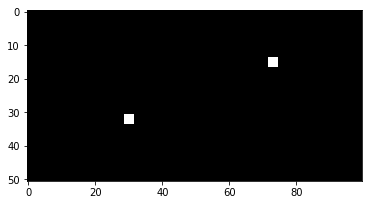

[22 28  2]
Video 31 go stop
0.0 894


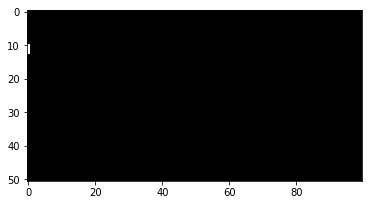

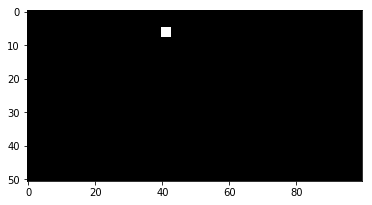

[20 74  2]
[ 7 42  2]
Video 33 go stop
0.0 894


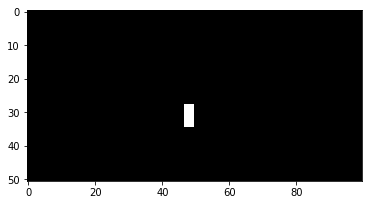

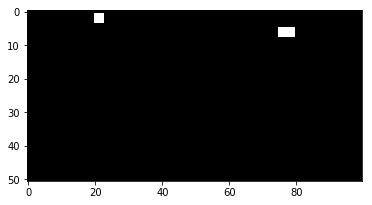

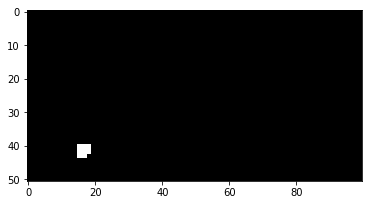

[42 17  2]
Video 36 go stop
0.0 894


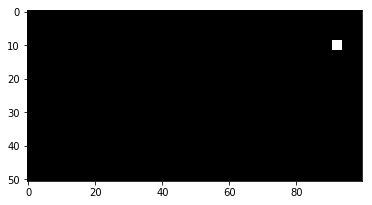

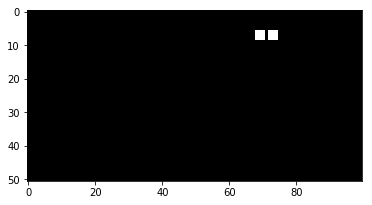

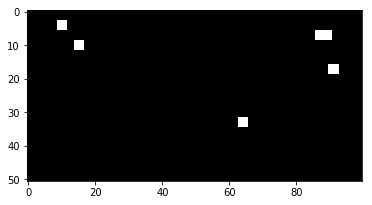

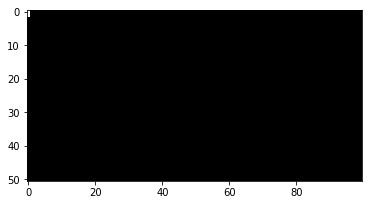

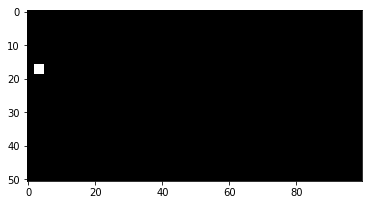

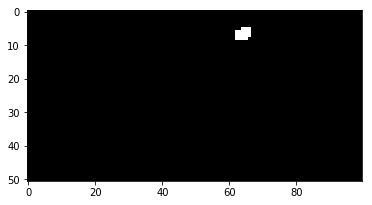

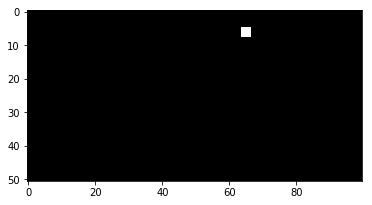

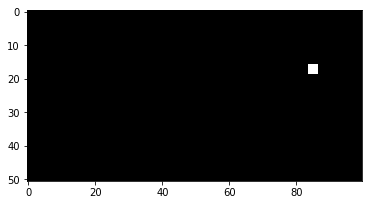

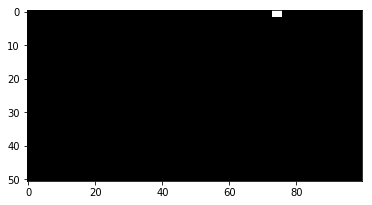

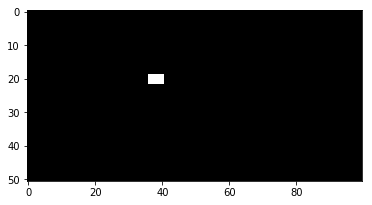

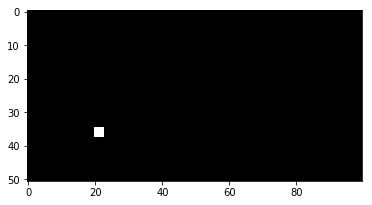

[37 23  2]
[20  0  2]
Video 47 go stop
0.0 894


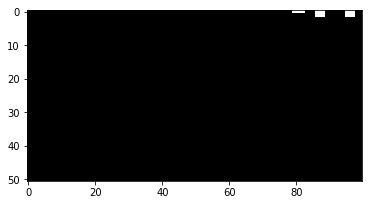

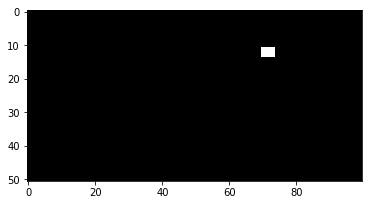

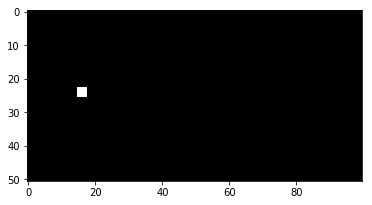

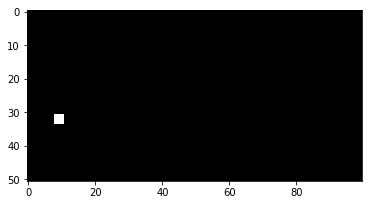

[33  9  2]
Video 51 go stop
0.0 894


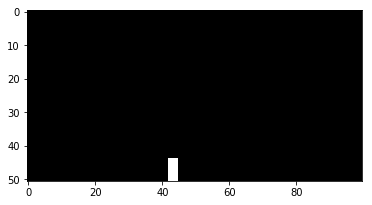

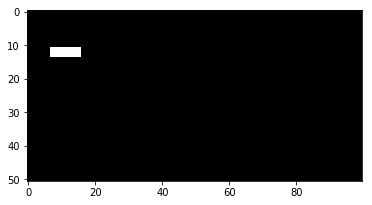

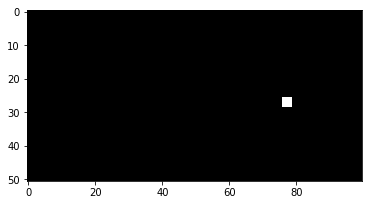

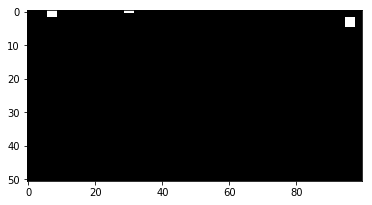

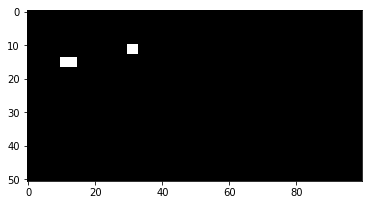

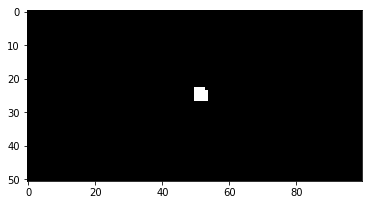

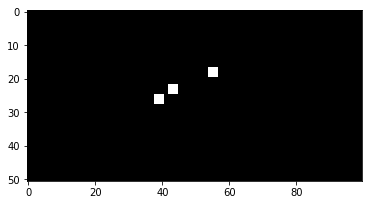

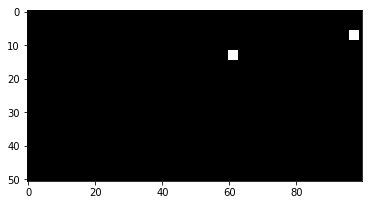

[13 62  2]
Video 59 go stop
0.0 894


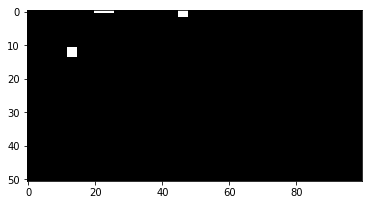

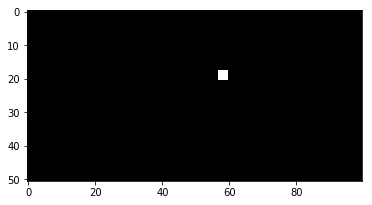

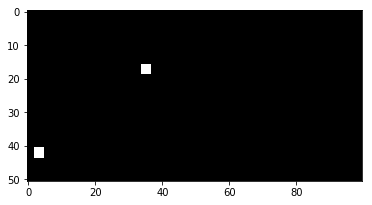

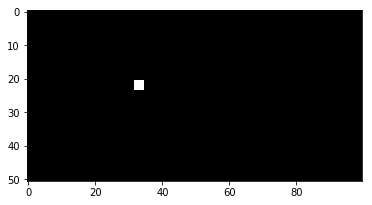

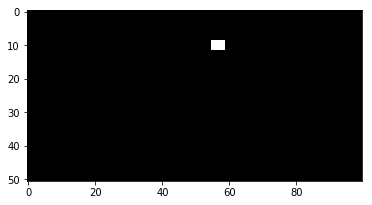

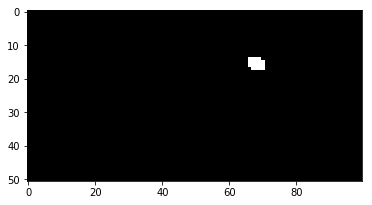

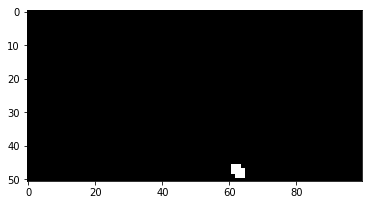

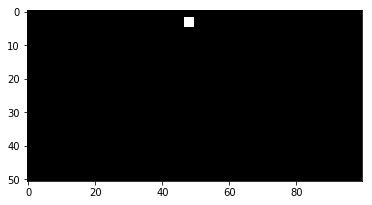

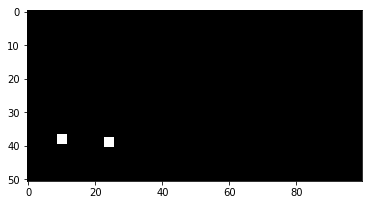

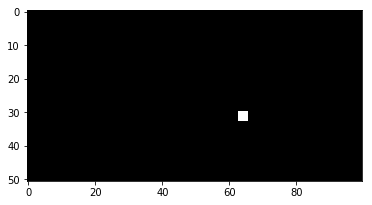

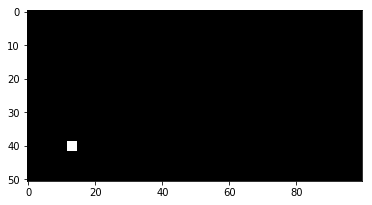

[42 14  2]
Video 70 go stop
0.0 894


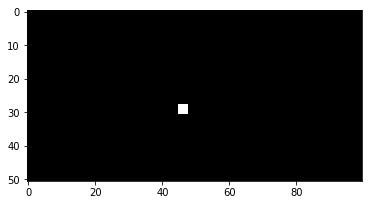

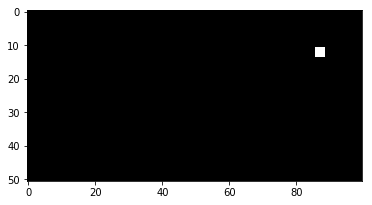

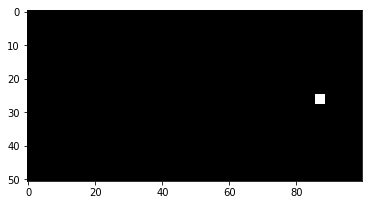

[29 88  2]
Video 73 go stop
0.0 894


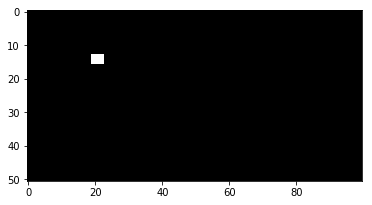

[15 21  2]
Video 74 go stop
0.0 894


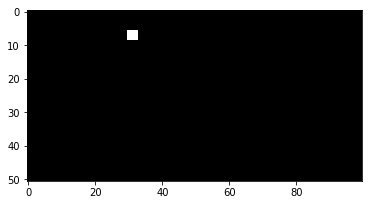

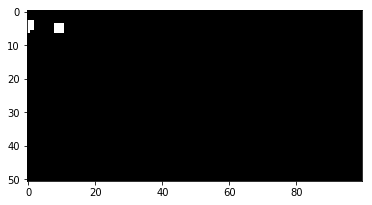

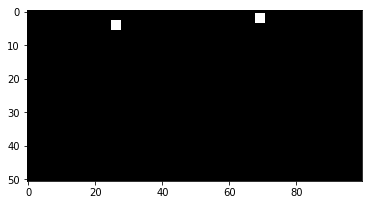

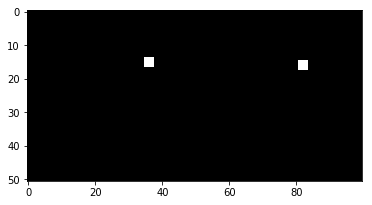

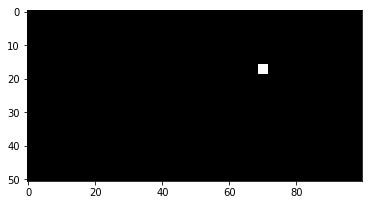

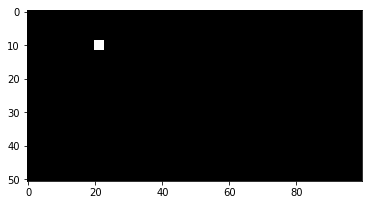

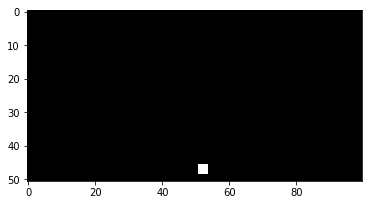

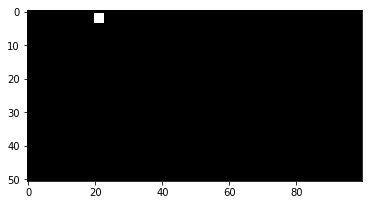

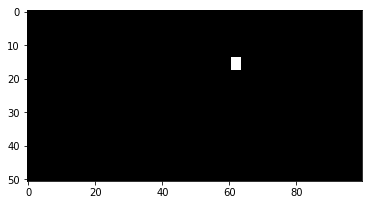

[17 62  2]
Video 83 go stop
0.0 894


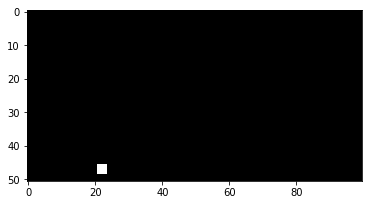

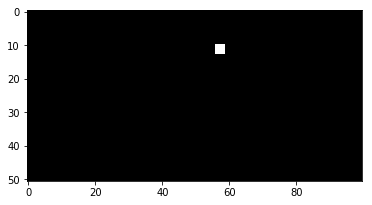

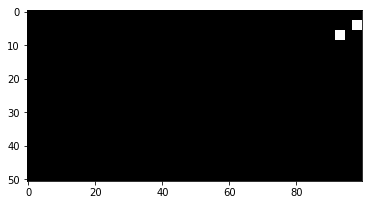

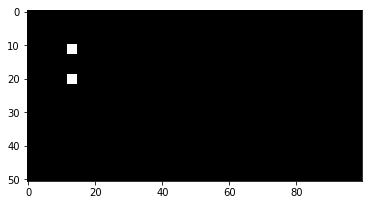

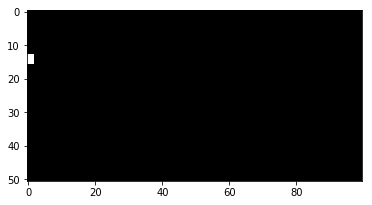

[15  0  2]
Video 88 go stop
0.0 894


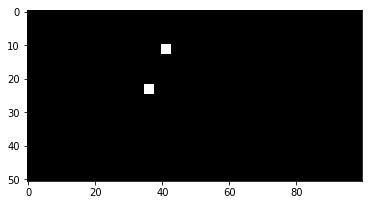

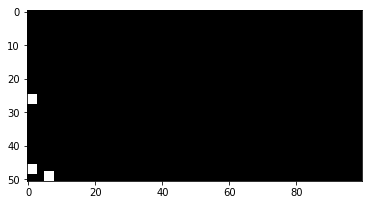

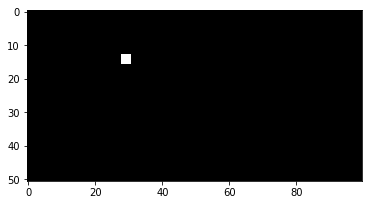

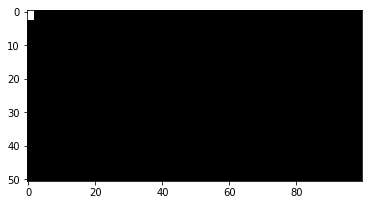

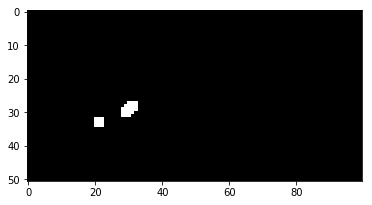

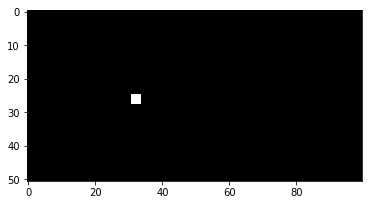

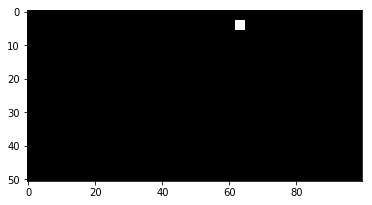

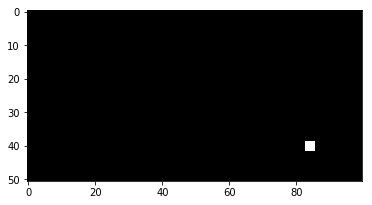

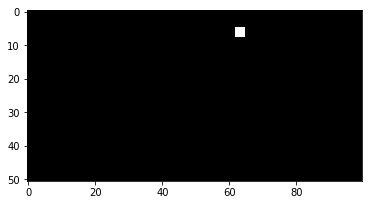

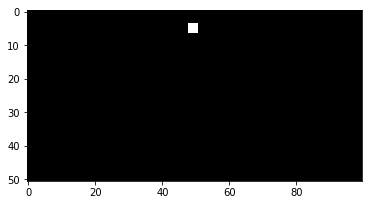

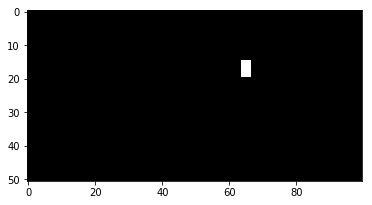

[23 59  2]
[18 66  2]
Video 99 go stop
0.0 894


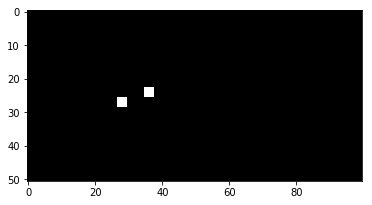

In [53]:
def save_res(images):
    for i in range(len(images)):
        np.save(str(i)+".npy", images[i])
        
def stats(images):
    maxi = np.max(images)
    mini = np.min(images)
    perc = np.percentile(images, [90, 95, 99])
    return (maxi, mini, perc) 

def histograms(images, mini, maxi):
    for i, image in enumerate(images):
        print(i)
        plt.hist(image, range=[mini, maxi])
        plt.show()   
        an_go_stop = locate_anomaly(image, p = verb)
        if an_go_stop:
            print(np.min(an_go_stop) * sampling / fps, max_frames // fps)
 
def max_suppr(image, size = 3, stepSize = 1):
    res = np.copy(image)
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            res[y,x] = np.any(image[y:y + size, x:x + size] >= np.max(image)*0.9)
    return res
    
    
verb=False
#histograms(an_go_stop_vec, int(mini), int(maxi))
#save_res(an_go_stop_vec)
(maxi, mini, perc) = stats(an_go_stop_vec)
print(maxi, mini, perc)
for i, image in enumerate(an_go_stop_vec):
    res = max_suppr(image)
    plt.imshow(res)
    plt.show()
    if(np.mean(image > perc[1]) < 0.03):
        tmp = np.zeros((image.shape[0], image.shape[1], 2))
        tmp[:,:,0] = image
        an_go_stop = locate_anomaly(tmp, seuil=perc[1], p = verb)
        if an_go_stop:
            print("Video", i+1, "go stop")
            #an_go_stop = locate_anomaly(tmp, seuil=perc[1], p = True)
            print(np.min(an_go_stop) * sampling / fps, max_frames // fps)
        
(maxi, mini, perc) = stats(an_stop_go_vec)
for i, image in enumerate(an_stop_go_vec):
    if(np.mean(image > perc[1]) < 0.01):
        tmp = np.zeros((image.shape[0], image.shape[1], 2))
        tmp[:,:,0] = image
        an_go_stop = locate_anomaly(tmp, seuil=perc[1], p = verb)
        if an_go_stop:
            print("Video", i+1, "stop go")
            print(np.min(an_go_stop) * sampling / fps, max_frames // fps)
        

In [47]:
a = np.asarray([1,2,3,4,5,6])
a > 2
print(np.any(a[0:2] > 2))

False
